# Imports

In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
#sc = SparkContext()
import pyspark
from pyspark import SparkConf, SparkContext 
import pandas as pd 
from pyspark.ml.feature import StringIndexer
from pyspark.sql.functions import *
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [2]:
spark_conf = SparkConf().set('spark.executor.memory', '6G').set('spark.driver.memory', '6G').set('spark.driver.maxResultSize', '6G')
spark_conf = SparkConf().setAppName("test")
sc = SparkContext(conf = spark_conf)
# sc=SparkContext.getOrCreate()
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)


# Read traffic weather merged data

In [3]:
df_merged_data = spark.read.parquet('/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/TrafficWeatherMerged.parquet')




In [4]:
df_merged_data.printSchema()

root
 |-- TR_EventId: string (nullable = true)
 |-- TR_Type: string (nullable = true)
 |-- TR_Severity: string (nullable = true)
 |-- TR_TMC: integer (nullable = true)
 |-- TR_StartTime: timestamp (nullable = true)
 |-- TR_EndTime: timestamp (nullable = true)
 |-- TR_LocationLat: double (nullable = true)
 |-- TR_LocationLng: double (nullable = true)
 |-- TR_Distance: double (nullable = true)
 |-- TR_AirportCode: string (nullable = true)
 |-- TR_Street: string (nullable = true)
 |-- TR_Side: string (nullable = true)
 |-- TR_City: string (nullable = true)
 |-- TR_County: string (nullable = true)
 |-- TR_State: string (nullable = true)
 |-- TR_ZipCode: integer (nullable = true)
 |-- TR_StartDate: date (nullable = true)
 |-- TR_EndDate: date (nullable = true)
 |-- WR_EventId: string (nullable = true)
 |-- WR_Type: string (nullable = true)
 |-- WR_Severity: string (nullable = true)
 |-- WR_StartTime: timestamp (nullable = true)
 |-- WR_EndTime: timestamp (nullable = true)
 |-- WR_TimeZone: 

In [5]:
df_merged_data.count()

5546343

In [6]:
df_merged_data[df_merged_data.TR_Type == 'Accident'].count()

326850

# Find missing values

In [8]:
def find_missing_values(df):
    missing_value_dict = {}
    for column_name in df.columns:
        missing_value_count = df.where(df[column_name].isNull()).count()
        missing_value_percent = (missing_value_count / df.count()) * 100
        missing_value_dict[column_name] = {}
        missing_value_dict[column_name]['count'] =  missing_value_count
        missing_value_dict[column_name]['percent'] =  missing_value_percent

    missing_value_pd = pd.DataFrame(missing_value_dict).T
    return missing_value_pd 

In [9]:
find_missing_values(df_merged_data)

,count,percent
TR_EventId,0.0,0.000000
TR_Type,0.0,0.000000
TR_Severity,712913.0,12.853749
TR_TMC,0.0,0.000000
TR_StartTime,0.0,0.000000
TR_EndTime,0.0,0.000000
TR_LocationLat,0.0,0.000000
TR_LocationLng,0.0,0.000000
TR_Distance,0.0,0.000000
TR_AirportCode,0.0,0.000000


In [10]:
df_merged_data.groupby('TR_Type').count().show()

+--------------+-------+
|       TR_Type|  count|
+--------------+-------+
|         Event|   4944|
|Broken-Vehicle|  62853|
|  Lane-Blocked|  51661|
|  Construction|  72974|
|    Congestion|4822216|
| Flow-Incident| 204845|
|      Accident| 326850|
+--------------+-------+



In [11]:
df_merged_data.groupby('WR_Type').count().show()

+-------------+-------+
|      WR_Type|  count|
+-------------+-------+
|         Cold| 107622|
|          Fog|1225215|
|        Storm|  39026|
|Precipitation|  76617|
|         Hail|   5589|
|         Rain|2529071|
|         Snow|1563203|
+-------------+-------+



In [12]:
df_merged_data.select('WR_Severity').show(4)

+-----------+
|WR_Severity|
+-----------+
|      Light|
|   Moderate|
|      Light|
|     Severe|
+-----------+
only showing top 4 rows



# Drop columns

In [13]:
df_merged_data.columns
drop_columns_list = ['TR_EventId', 'TR_TMC', 'TR_LocationLat', 'TR_LocationLng', 'TR_Distance', 'TR_AirportCode',
                    'TR_Side', 'TR_County','TR_StartDate','TR_EndDate','TR_EndTime', 'WR_EventId', 'WR_StartTime', 'WR_EndTime', 'WR_TimeZone',
                    'WR_LocationLat', 'WR_LocationLng','WR_AirportCode','WR_City','WR_County', 'WR_State', 'WR_ZipCode',
                    'WR_StartDate','WR_EndDate','TR_Severity']






In [14]:
df_truc_cols = df_merged_data
for col_names in drop_columns_list:
    df_truc_cols = df_truc_cols.drop(col_names)

In [15]:
df_truc_cols.printSchema()

root
 |-- TR_Type: string (nullable = true)
 |-- TR_StartTime: timestamp (nullable = true)
 |-- TR_Street: string (nullable = true)
 |-- TR_City: string (nullable = true)
 |-- TR_State: string (nullable = true)
 |-- TR_ZipCode: integer (nullable = true)
 |-- WR_Type: string (nullable = true)
 |-- WR_Severity: string (nullable = true)



In [13]:
#df_truc_cols = df_truc_cols.filter(df_truc_cols.TR_Severity.isNotNull())

In [16]:
df_truc_cols.groupby('TR_Type').count().show()

+--------------+-------+
|       TR_Type|  count|
+--------------+-------+
|         Event|   4944|
|Broken-Vehicle|  62853|
|  Lane-Blocked|  51661|
|  Construction|  72974|
|    Congestion|4822216|
| Flow-Incident| 204845|
|      Accident| 326850|
+--------------+-------+



In [17]:
find_missing_values(df_truc_cols)

,count,percent
TR_Type,0.0,0.0
TR_StartTime,0.0,0.0
TR_Street,0.0,0.0
TR_City,0.0,0.0
TR_State,0.0,0.0
TR_ZipCode,0.0,0.0
WR_Type,0.0,0.0
WR_Severity,0.0,0.0


In [29]:
df_truc_cols.write.parquet('/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/TW_NonNull.parquet')




# Read non null data with ralivant columns

In [18]:
df_truc_cols=spark.read.parquet('/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/TW_NonNull.parquet')


# Make an accident column =1 if accident 0 otherwise

In [19]:
from pyspark.sql import functions as F
df_accident=df_truc_cols.withColumn('Accident', F.when((F.col("TR_Type") == 'Accident') , 1) \
    .otherwise(0))

In [20]:
df_accident.groupby('Accident').count().show()

+--------+-------+
|Accident|  count|
+--------+-------+
|       1| 326850|
|       0|5219493|
+--------+-------+



In [21]:
df_accident = df_accident.drop('TR_Type')

In [22]:
df_accident.printSchema()

root
 |-- TR_StartTime: timestamp (nullable = true)
 |-- TR_Street: string (nullable = true)
 |-- TR_City: string (nullable = true)
 |-- TR_State: string (nullable = true)
 |-- TR_ZipCode: integer (nullable = true)
 |-- WR_Type: string (nullable = true)
 |-- WR_Severity: string (nullable = true)
 |-- Accident: integer (nullable = false)



# Make hour column 

In [23]:

df_accident = df_accident.withColumn('Hour', hour(df_accident.TR_StartTime))

In [24]:
df_accident.select('Hour').show(10)

+----+
|Hour|
+----+
|  20|
|  20|
|  20|
|  20|
|  21|
|  21|
|  21|
|  21|
|  21|
|  21|
+----+
only showing top 10 rows



# downsample to remove skewness

In [25]:
df_acc_downsample=df_accident.sampleBy('Accident', fractions={0: 326850./5219493, 1: 1.0}).cache()

In [26]:
df_acc_downsample.groupby('Accident').count().show()

+--------+------+
|Accident| count|
+--------+------+
|       1|326850|
|       0|326642|
+--------+------+



In [42]:
df_acc_downsample.write.parquet('/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/Accident_downsampled.parquet')



In [27]:
df_acc_downsample=spark.read.parquet('/Users/pprusty05/workspace/Data_mining/Project/data_folder/traffic_weather_data/Accident_downsampled.parquet')

In [72]:
# def get_data_types(df):
#     col_data_type = {}
#     for types in df.dtypes:
#         col_data_type[types[0]] = types[1]
#     return col_data_type


# col_data_type = get_data_types(df_acc_downsample)



# convert to panda df

In [28]:
accident_panda_df=df_acc_downsample.toPandas()

In [29]:
accident_panda_df.head()

,TR_StartTime,TR_Street,TR_City,TR_State,TR_ZipCode,WR_Type,WR_Severity,Accident,Hour
0,2016-09-27 20:08:00,E Main St,Westfield,MA,1085,Rain,Light,0,20
1,2016-09-27 20:08:00,E Main St,Westfield,MA,1085,Rain,Moderate,0,20
2,2019-12-10 13:40:00,East St,Pittsfield,MA,1201,Rain,Light,0,13
3,2019-12-10 20:05:00,East St,Pittsfield,MA,1201,Rain,Light,0,20
4,2019-12-10 21:54:00,South St,Pittsfield,MA,1201,Snow,Heavy,0,21


## drop starttime column

In [30]:
accident_panda_df=accident_panda_df.drop(['TR_StartTime'],axis=1)

In [31]:
accident_panda_df.head()

,TR_Street,TR_City,TR_State,TR_ZipCode,WR_Type,WR_Severity,Accident,Hour
0,E Main St,Westfield,MA,1085,Rain,Light,0,20
1,E Main St,Westfield,MA,1085,Rain,Moderate,0,20
2,East St,Pittsfield,MA,1201,Rain,Light,0,13
3,East St,Pittsfield,MA,1201,Rain,Light,0,20
4,South St,Pittsfield,MA,1201,Snow,Heavy,0,21


In [32]:
len(accident_panda_df['TR_Street'].unique())

24540

In [33]:
len(accident_panda_df['TR_City'].unique())

1726

In [34]:
len(accident_panda_df['TR_State'].unique())

49

In [35]:
len(accident_panda_df['WR_Type'].unique())

7

In [36]:
len(accident_panda_df['WR_Severity'].unique())

6

In [37]:
len(accident_panda_df['TR_ZipCode'].unique())

1908

In [38]:
accident_panda_df.select_dtypes(include=['object', 'category']).columns

Index(['TR_Street', 'TR_City', 'TR_State', 'WR_Type', 'WR_Severity'], dtype='object')

In [39]:
accident_panda_df.columns

Index(['TR_Street', 'TR_City', 'TR_State', 'TR_ZipCode', 'WR_Type',
       'WR_Severity', 'Accident', 'Hour'],
      dtype='object')

# convert catagorical to numerical columns

In [40]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_lable_encoded = accident_panda_df[['TR_Street', 'TR_City', 'TR_State', 'TR_ZipCode']].apply(le.fit_transform)


In [41]:
df_lable_encoded.head()

,TR_Street,TR_City,TR_State,TR_ZipCode
0,5791,1670,17,0
1,5791,1670,17,0
2,6423,1229,17,1
3,6423,1229,17,1
4,19696,1229,17,1


In [42]:
accident_panda_df['TR_Street'] = le.fit_transform(accident_panda_df['TR_Street'])

In [43]:
accident_panda_df['TR_City'] = le.fit_transform(accident_panda_df['TR_City'])

In [44]:
accident_panda_df['TR_State'] = le.fit_transform(accident_panda_df['TR_State'])

In [45]:
accident_panda_df['TR_ZipCode'] = le.fit_transform(accident_panda_df['TR_ZipCode'])

In [46]:
accident_panda_df.head(10)

,TR_Street,TR_City,TR_State,TR_ZipCode,WR_Type,WR_Severity,Accident,Hour
0,5791,1670,17,0,Rain,Light,0,20
1,5791,1670,17,0,Rain,Moderate,0,20
2,6423,1229,17,1,Rain,Light,0,13
3,6423,1229,17,1,Rain,Light,0,20
4,19696,1229,17,1,Snow,Heavy,0,21
5,14923,1229,17,1,Rain,Light,0,22
6,14923,1229,17,1,Snow,Light,0,22
7,3722,309,17,6,Rain,Heavy,0,10
8,8540,309,17,6,Rain,Light,0,11
9,3722,309,17,6,Rain,Moderate,0,11


In [81]:
df_dummies = pd.get_dummies(accident_panda_df, columns=['WR_Severity','WR_Type'])

In [82]:
df_dummies.head()

,TR_Street,TR_City,TR_State,TR_ZipCode,Accident,Hour,WR_Severity_Heavy,WR_Severity_Light,WR_Severity_Moderate,WR_Severity_Other,WR_Severity_Severe,WR_Severity_UNK,WR_Type_Cold,WR_Type_Fog,WR_Type_Hail,WR_Type_Precipitation,WR_Type_Rain,WR_Type_Snow,WR_Type_Storm
0,5791,1670,17,0,0,20,0,1,0,0,0,0,0,0,0,0,1,0,0
1,5791,1670,17,0,0,20,0,0,1,0,0,0,0,0,0,0,1,0,0
2,6423,1229,17,1,0,13,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6423,1229,17,1,0,20,0,1,0,0,0,0,0,0,0,0,1,0,0
4,19696,1229,17,1,0,21,1,0,0,0,0,0,0,0,0,0,0,1,0


In [49]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler 

# target =accident

In [50]:
y=df_dummies['Accident']

In [51]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Accident, dtype: int32

In [52]:
X=df_dummies.drop(['Accident'],axis=1)

In [53]:
X.head()

,TR_Street,TR_City,TR_State,TR_ZipCode,Hour,WR_Severity_Heavy,WR_Severity_Light,WR_Severity_Moderate,WR_Severity_Other,WR_Severity_Severe,WR_Severity_UNK,WR_Type_Cold,WR_Type_Fog,WR_Type_Hail,WR_Type_Precipitation,WR_Type_Rain,WR_Type_Snow,WR_Type_Storm
0,5791,1670,17,0,20,0,1,0,0,0,0,0,0,0,0,1,0,0
1,5791,1670,17,0,20,0,0,1,0,0,0,0,0,0,0,1,0,0
2,6423,1229,17,1,13,0,1,0,0,0,0,0,0,0,0,1,0,0
3,6423,1229,17,1,20,0,1,0,0,0,0,0,0,0,0,1,0,0
4,19696,1229,17,1,21,1,0,0,0,0,0,0,0,0,0,0,1,0


# train test split

In [54]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Standardization 

In [55]:
scaler = StandardScaler()

X_train_scalar = scaler.fit_transform(X_train)
X_test_scalar=scaler.transform(X_test)

# Naive bayes classifier

In [56]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)

In [58]:
accuracy_score(y_test,y_pred)

0.6207719674075207

In [60]:
print(f1_score(y_test,y_pred))
print(precision_score(y_test,y_pred))
print(recall_score(y_test,y_pred))

0.6612725769306992
0.5965771075572435
0.7417065244051999


# KNN classifier

In [61]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
knn_pred=neigh.predict(X_test)

In [62]:
print(accuracy_score(y_test,knn_pred))
print(f1_score(y_test,knn_pred))
print(precision_score(y_test,knn_pred))
print(recall_score(y_test,knn_pred))

0.8675873149458705
0.8716754776857544
0.8441058632623462
0.9011068187392691


In [63]:
k_range=range(1,20)
score={}
score_list=[]
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    knn_pred=neigh.predict(X_test)
    score[k]=accuracy_score(y_test,knn_pred)
    score_list.append(accuracy_score(y_test,knn_pred))
    

In [66]:
score_list

[0.8676408706629433,
 0.8500286905627176,
 0.8675873149458705,
 0.8610611682797139,
 0.8631498412455529,
 0.8599211965877357,
 0.8587812248957576,
 0.8556137867717378,
 0.8543054971118167,
 0.8529819058184461,
 0.8498450709613251,
 0.8483225584331128,
 0.8454152480777323,
 0.8445277533376688,
 0.8424390803718297,
 0.8412226005126047,
 0.8386060211927623,
 0.8377950346199456,
 0.8359435369725718]

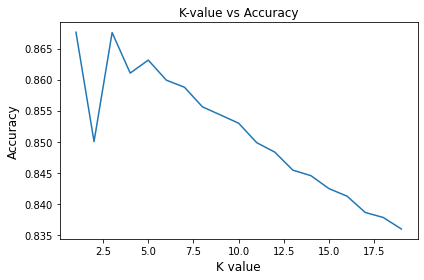

In [68]:
from matplotlib import rcParams
plt.plot(k_range,score_list)
plt.xlabel("K value", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("K-value vs Accuracy")
rcParams.update({'figure.autolayout': True})
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.tight_layout()
plt.savefig('/Users/pprusty05/google_drive/Data_Mining/Project/plots/K_accuracy_accident.pdf')
plt.show()

In [69]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
RF.fit(X_train, y_train)
rf_pred=neigh.predict(X_test)


In [70]:
print(accuracy_score(y_test,rf_pred))
print(f1_score(y_test,rf_pred))
print(precision_score(y_test,rf_pred))
print(recall_score(y_test,rf_pred))

0.8359435369725718
0.8415678451365031
0.8122744712107598
0.8730531027716458


In [83]:
df_dummies.columns

Index(['TR_Street', 'TR_City', 'TR_State', 'TR_ZipCode', 'Accident', 'Hour',
       'WR_Severity_Heavy', 'WR_Severity_Light', 'WR_Severity_Moderate',
       'WR_Severity_Other', 'WR_Severity_Severe', 'WR_Severity_UNK',
       'WR_Type_Cold', 'WR_Type_Fog', 'WR_Type_Hail', 'WR_Type_Precipitation',
       'WR_Type_Rain', 'WR_Type_Snow', 'WR_Type_Storm'],
      dtype='object')

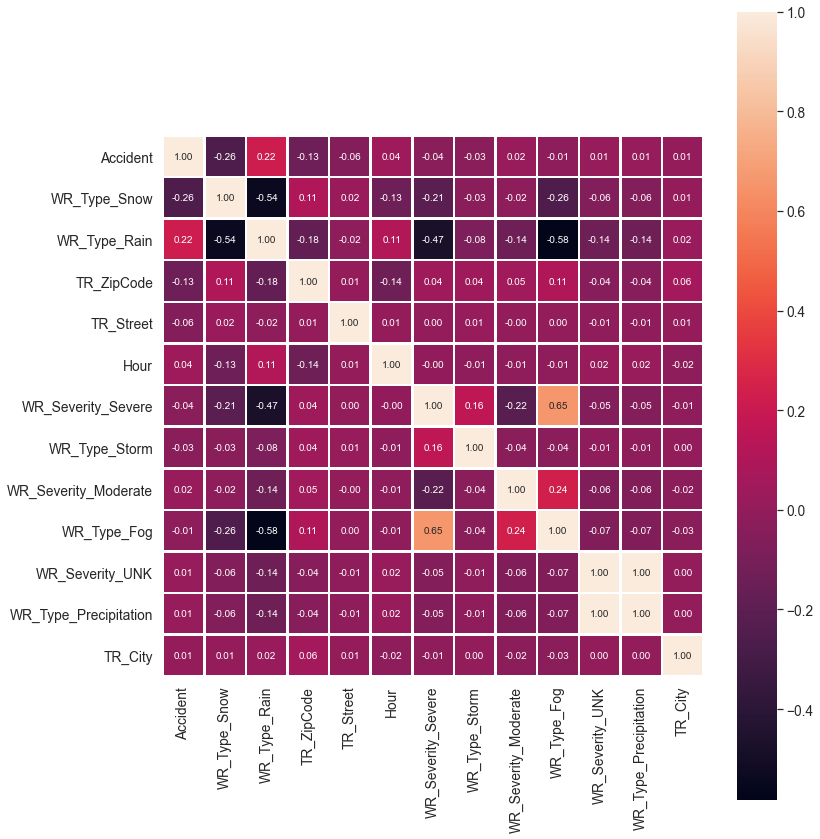

Final list of selected features:
['Accident', 'WR_Type_Snow', 'WR_Type_Rain', 'TR_ZipCode', 'TR_Street', 'Hour', 'WR_Severity_Severe', 'WR_Type_Storm', 'WR_Severity_Moderate', 'WR_Type_Fog', 'WR_Severity_UNK', 'WR_Type_Precipitation', 'TR_City']


In [98]:
import numpy as np
import seaborn as sns
target = 'Accident'
#plot heatmap
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.savefig('/Users/pprusty05/google_drive/Data_Mining/Project/plots/correlation.pdf')
    plt.show()
    
    

#set the threshold for feature selection
corr_theshold=.01

#find the correlation values
corr = df_dummies.corr()
corr_abs = corr.abs()

num_cols = len(df_dummies)
#sort the correlation values in descending order
sort_corr = corr_abs.nlargest(num_cols, target)[target]
#print(sort_corr)

#filter the features with above correlation values
cols_abv_corr_limit = list(sort_corr[sort_corr.values > corr_theshold].index)
cols_bel_corr_limit = list(sort_corr[sort_corr.values <= corr_theshold].index)
selected_feats=cols_abv_corr_limit
nr_feats = len(cols_abv_corr_limit)

#plot the heatmap with selected features
plot_corr_matrix(df_dummies, nr_feats, target)

#drop the features from df_train with correaltion value below threshold
#for df in [df_dummies]:
    #df.drop(cols_bel_corr_limit, inplace=True, axis=1)

print("Final list of selected features:")
print(selected_feats)


In [85]:
len(selected_feats)

13

In [86]:
df_dummies.shape

(653523, 19)

In [87]:
df_selected_feat=df_dummies#drop the features from df_train with correaltion value below threshold
cols_abv_corr_limit
for df in [df_selected_feat]:
    df.drop(cols_bel_corr_limit, inplace=True, axis=1)

In [88]:
df_selected_feat.shape

(653523, 13)

In [89]:
y=df_selected_feat['Accident']

In [90]:
X=df_selected_feat.drop(['Accident'],axis=1)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [92]:
scaler = StandardScaler()

X_train_scalar = scaler.fit_transform(X_train)
X_test_scalar=scaler.transform(X_test)

In [93]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train, y_train)
knn_pred=neigh.predict(X_test)

In [94]:
print(accuracy_score(y_test,knn_pred))
print(f1_score(y_test,knn_pred))
print(precision_score(y_test,knn_pred))
print(recall_score(y_test,knn_pred))

0.869568876477564
0.8731490989181064
0.847716469449381
0.9001549531305135


# Visualization

In [29]:
accident_rows=df_dummies[df_dummies.Accident==1]

In [31]:
no_accident_rows=df_dummies[df_dummies.Accident==0]

## weather vs accident

In [65]:
accident_panda_df

,TR_Street,TR_City,TR_State,TR_ZipCode,WR_Type,WR_Severity,Accident,Hour
0,5791,1670,17,0,Rain,Light,0,20
1,5791,1670,17,0,Rain,Moderate,0,20
2,6423,1229,17,1,Rain,Light,0,13
3,6423,1229,17,1,Rain,Light,0,20
4,19696,1229,17,1,Snow,Heavy,0,21
...,...,...,...,...,...,...,...,...
653518,11207,1591,45,1894,Fog,Severe,1,16
653519,11207,1591,45,1894,Fog,Severe,1,16
653520,11207,1591,45,1894,Fog,Severe,1,16
653521,11206,1591,45,1894,Fog,Severe,0,15


In [22]:
weather_sev_list = accident_panda_df.WR_Severity.unique()

In [23]:
weather_sev_list

array(['Light', 'Moderate', 'Heavy', 'Severe', 'Other', 'UNK'],
      dtype=object)

In [24]:
weather_type_list = accident_panda_df.WR_Type.unique()

In [25]:
weather_str_list = []
accident_count_list = []
for weather_type in weather_type_list:
    for weather_sev in weather_sev_list:
        accident_count, _ = accident_panda_df[(accident_panda_df.WR_Severity == weather_sev) & 
                                           (accident_panda_df.WR_Type == weather_type)].shape
        if accident_count > 0:
            weather_str = weather_type + ' - ' + weather_sev
            weather_str_list.append(weather_str)
            accident_count_list.append(accident_count)
        #print(weather_type + ' ' + weather_sev + ' ' + str(accident_count) )
      

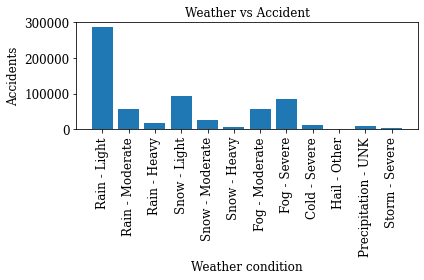

In [27]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.tight_layout()
#plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.xticks(rotation=90)
plt.bar(weather_str_list, accident_count_list)
plt.xlabel('Weather condition',fontsize=12)
plt.ylabel('Accidents',fontsize=12)
plt.title('Weather vs Accident')
plt.savefig('/Users/pprusty05/google_drive/Data_Mining/Project/plots/Weather_vs_Accident.pdf')
plt.show()